In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

In [34]:
data = pd.read_csv('model_data3.csv')
data['PO_Document_Date'] = pd.to_datetime(data['PO_Document_Date'] , format='%Y-%m-%d')
# data = data[data['PO_Document_Date']>=pd.to_datetime('2021-01-01', format='%Y-%m-%d')]

In [50]:
data['days_late'] = np.where(data['days_late']>0, data['days_late'], 0)
data = data[data['days_late'] < 25]

In [51]:
mg_data = data[data['Material_Group']=='017']

/Users/whitmanblass/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


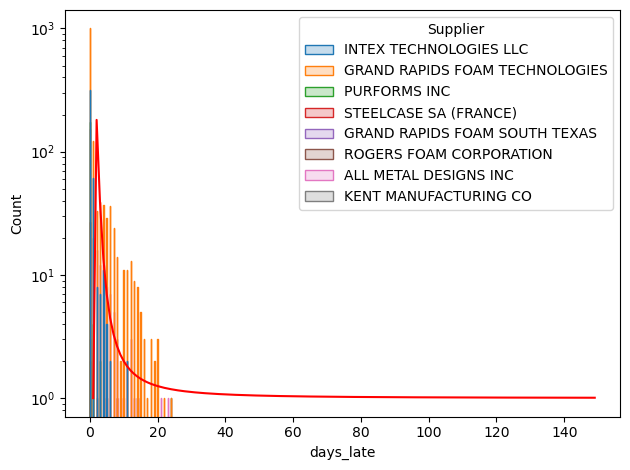

In [52]:
fig, ax = plt.subplots()
plot = sns.histplot(data=mg_data,
                    x = 'days_late',
                    hue='Supplier',
            kde=False,
            element='step',
                    )
s = []
for x in range(1, 150):
    new_val = x**(30/x**2)
    s.append(new_val)
sns.lineplot(range(1,150), s, color='red')
plot.set_yscale('log')
plt.tight_layout()

Fitting 10 distributions: 100%|██████████| 10/10 [00:01<00:00,  8.48it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,6.246945,901.104734,-13435.333818,inf,0.73345,0.0
expon,6.351737,2031.437392,-13405.120118,inf,0.73345,0.0
exponpow,6.894843,781.837443,-13210.242268,inf,0.73345,0.0
chi2,7.409747,848.594605,-13045.958616,inf,0.73345,0.0
powerlaw,7.545552,697.514276,-13004.531303,inf,0.73345,0.0


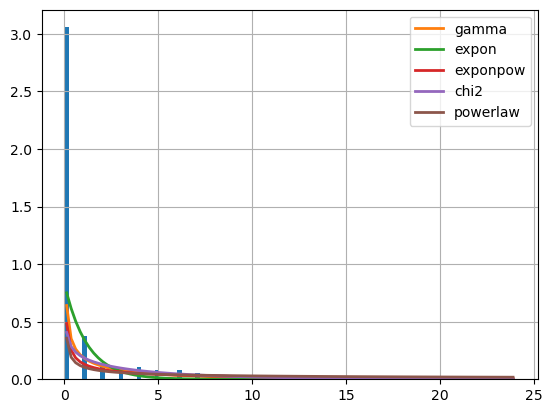

In [53]:
f = Fitter(mg_data['days_late'],
           distributions=get_common_distributions())
f.fit()
f.summary()

In [54]:
grouped = mg_data.groupby('Supplier').resample('M', on='PO_Document_Date')
late_p = grouped.mean()['days_late'].reset_index()
late_p

,Supplier,PO_Document_Date,days_late
0,ALL METAL DESIGNS INC,2021-03-31,1.217391
1,ALL METAL DESIGNS INC,2021-04-30,1.379310
2,ALL METAL DESIGNS INC,2021-05-31,2.900000
3,ALL METAL DESIGNS INC,2021-06-30,0.833333
4,ALL METAL DESIGNS INC,2021-07-31,4.111111
...,...,...,...
205,STEELCASE SA (FRANCE),2022-04-30,14.000000
206,STEELCASE SA (FRANCE),2022-05-31,NaN
207,STEELCASE SA (FRANCE),2022-06-30,0.000000
208,STEELCASE SA (FRANCE),2022-07-31,0.000000


In [55]:
dates = list(late_p['PO_Document_Date'].unique())
MVEF_Ingest = pd.DataFrame({'Month': dates})
keep_columns = ['Month']
perf_columns = []
for supplier in set(late_p['Supplier']):
    sup_data = late_p[late_p['Supplier'] == supplier][['PO_Document_Date', 'days_late']]
    non_nulls = [x for x in sup_data['days_late'] if x > -1000]
    if late_p[late_p['Supplier'] == supplier]['days_late'].count() < 12:
        continue
    sup_data = sup_data.rename(
        columns={'days_late': f'{supplier} days_late', 'PO_Document_Date': f'{supplier}_date'})
    keep_columns.append(f'{supplier} days_late')
    perf_columns.append(f'{supplier} days_late')
    MVEF_Ingest = pd.merge(MVEF_Ingest, sup_data, how='left', left_on='Month', right_on=f'{supplier}_date')
MVEF_Ingest = MVEF_Ingest[keep_columns]
MVEF_Clean = MVEF_Ingest[perf_columns].interpolate(method='linear', axis=0, limit_direction='forward')
MVEF_Clean['Month'] = MVEF_Ingest['Month']
MVEF_Clean = MVEF_Clean.dropna()
MVEF_Clean = MVEF_Clean[keep_columns]
MVEF_Clean = MVEF_Clean.sort_values(['Month'], ascending=True)
MVEF_Clean

,Month,INTEX TECHNOLOGIES LLC days_late,ALL METAL DESIGNS INC days_late,STEELCASE SA (FRANCE) days_late,GRAND RAPIDS FOAM TECHNOLOGIES days_late,PURFORMS INC days_late
44,2018-12-31,0.000000,0.000000,5.000000,0.161290,0.000000
43,2019-01-31,0.000000,0.000000,2.500000,0.161290,0.000000
20,2019-02-28,0.125000,0.000000,0.000000,1.785714,0.000000
21,2019-03-31,0.750000,0.000000,0.000000,0.117647,0.000000
22,2019-04-30,0.111111,0.000000,0.000000,0.548387,0.000000
23,2019-05-31,0.153846,0.000000,0.000000,1.114286,0.000000
24,2019-06-30,0.857143,0.000000,0.000000,2.815789,0.000000
25,2019-07-31,1.250000,0.000000,0.000000,5.121212,0.000000
26,2019-08-31,1.035714,0.000000,0.000000,1.883721,0.000000
27,2019-09-30,0.000000,0.000000,0.000000,0.420000,0.000000


0.0
0.0
0.0
0.0
0.9999999999999892


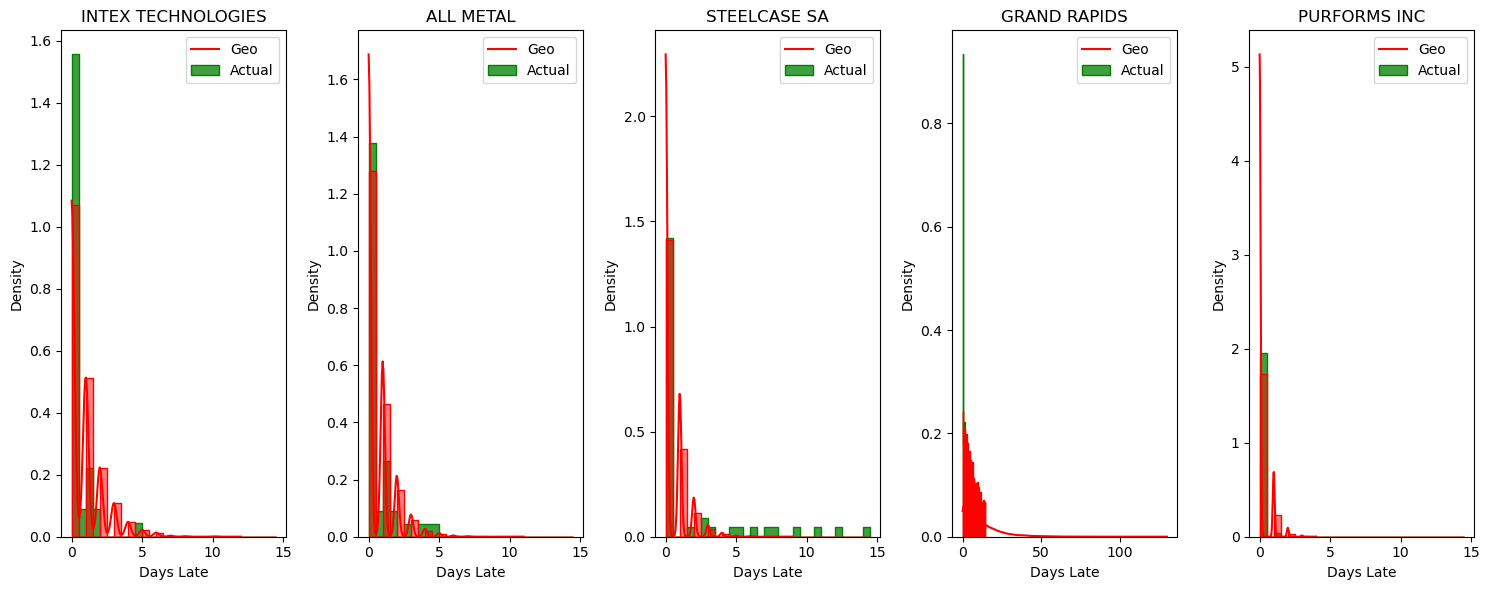

In [81]:
from scipy.stats import chisquare
def cs(n, y):
    return chisquare(n, np.sum(n)/np.sum(y) * y)
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 6))
bins = []
for i in range(30):
    bins.append(i//2 + ((i%2)/2))
for index, supplier in enumerate(perf_columns):
    mu = MVEF_Clean[supplier].mean()
    std = MVEF_Clean[supplier].std()
    plot = sns.histplot(
        data=MVEF_Clean[supplier],
        kde=False,
        element='step',
        ax=ax[index],
        bins=bins,
        stat='density',
        label='Actual',
        color='Green'
    )
    plot.set_xlabel('Days Late')
    Name = supplier.split()[0] + ' ' +supplier.split()[1]
    plot.set_title(f'{Name}')
    p = len(MVEF_Clean[MVEF_Clean[supplier]==0]) / len(MVEF_Clean[supplier])
    z = np.random.geometric(p=p, size=10000)
    z = [i-1 for i in z]
    sns.histplot(
        data=z,
        kde=True,
        element='step',
        ax=ax[index],
        bins=bins,
        color='red',
        label='Geo',
        stat='density'
    )
    plot.legend(labels=['Geo','Actual'])
    plt.tight_layout()
    binned_data = np.histogram(MVEF_Clean[supplier], bins)[0]
    binned_data = np.where(binned_data == 0, .01, binned_data)
    binned_data = binned_data/ sum(binned_data)
    binned_z = np.histogram(z, bins)[0]
    binned_z = np.where(binned_z == 0, .01, binned_z)
    binned_z = binned_z/ sum(binned_z)
    p_val = chisquare(binned_data, binned_z)[1]
    print(p_val)

In [79]:
binned_z.sum()

1.0017999999999998

In [80]:
binned_data.sum()

1.0024

In [59]:
MVEF_Clean[supplier]

44    0.000000
43    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    1.200000
31    0.166667
32    0.250000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.333333
41    0.142857
42    0.071429
18    0.000000
19    0.000000
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.000000
Name: PURFORMS INC days_late, dtype: float64